In [2]:
import pandas as pd
import re
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials
#from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from update_deals import deals_df
from Contacts import contacts_df
from Spend import spend_df
from Calls import calls_df

In [3]:
# Загрузка данных из Excel файла
file_path = 'update_deals.xlsx'
deals_df = pd.read_excel(file_path)

# Просмотр первых 5 строк данных
print(deals_df.head())

                    Id Deal Owner Name        Closing Date            Quality  \
0  5805028000056864768        Ben Hall 2024-06-20 23:45:36            C - Low   
1  5805028000056859648   Ulysses Adams 2024-06-21 00:00:00  E - Non Qualified   
2  5805028000056832000   Ulysses Adams 2024-06-21 00:00:00     D - Non Target   
3  5805028000056823808        Eva Kent 2024-06-21 00:00:00  E - Non Qualified   
4  5805028000056872960        Ben Hall 2024-06-21 00:00:00     D - Non Target   

      Stage                  Lost Reason       Page  \
0  New Lead               Invalid number  /eng/test   
1  New Lead  Conditions are not suitable    /at-eng   
2      Lost                   Non target    /at-eng   
3      Lost               Invalid number       /eng   
4      Lost                   Non target       /eng   

                            Campaign       SLA                  Ad  ...  \
0                      03.07.23women       NaN                 v16  ...   
1  performancemax_digitalmarkt_r

### Анализ эффективности работы отдела продаж:
1. Оцените эффективность отдельных владельцев сделок и рекламных кампаний с точки зрения количества
обработанных сделок, коэффициента конверсии и общей суммы продаж.

In [ ]:
Анализ эффективности отдельных владельцев сделок и рекламных кампаний

Для оценки эффективности владельцев сделок и рекламных кампаний необходимо провести анализ по нескольким ключевым метрикам: 
количество обработанных сделок, коэффициент конверсии, и общая сумма продаж. Ниже представлен план анализа, который можно применить к данным:

1. Количество обработанных сделок
Описание: Анализ количества сделок, обработанных каждым владельцем сделок и каждой рекламной кампанией.
Цель: Определить, кто из владельцев сделок (менеджеров) и какие кампании были наиболее активными и обработали наибольшее количество сделок.
Методы анализа:
Группировка данных по владельцам сделок и рекламным кампаниям.
Подсчет количества сделок в каждой группе.
Построение столбчатой диаграммы для наглядного сравнения активности.

2. Коэффициент конверсии
Описание: Коэффициент конверсии показывает долю успешных сделок среди всех обработанных сделок.
Цель: Оценить, насколько эффективно каждый владелец сделок и каждая рекламная кампания переводят потенциальных клиентов в реальных покупателей.
Методы анализа:
Определить успешные сделки на основе статуса ("Waiting For Payment" или "Payment Done").
Рассчитать коэффициент конверсии как отношение числа успешных сделок к общему числу обработанных сделок для каждого владельца и кампании.
Сравнить коэффициенты конверсии между владельцами сделок и рекламными кампаниями. Использовать для этого столбчатые диаграммы или таблицы.
    
3. Общая сумма продаж
Описание: Общая сумма продаж, связанная с каждым владельцем сделок и каждой рекламной кампанией.
Цель: Оценить, какие владельцы сделок и кампании приносят наибольшую выручку.
Методы анализа:
Группировка данных по владельцам сделок и рекламным кампаниям.
Суммирование дохода от всех успешных сделок в каждой группе.
Построение диаграммы для сравнения суммы продаж по владельцам сделок и кампаниям.

In [4]:
# 1. Подсчет количества обработанных сделок по владельцам сделок и рекламным кампаниям
deals_count = deals_df.groupby(['Deal Owner Name', 'Campaign']).size().reset_index(name='total_deals')

# 2. Подсчет количества успешных сделок и расчет коэффициента конверсии
successful_deals = deals_df[deals_df['Stage'].isin(['Waiting For Payment', 'Payment Done'])]
conversion_rate = successful_deals.groupby(['Deal Owner Name', 'Campaign']).size().reset_index(name='successful_deals')
conversion_rate = pd.merge(deals_count, conversion_rate, on=['Deal Owner Name', 'Campaign'], how='left').fillna(0)
conversion_rate['conversion_rate'] = (conversion_rate['successful_deals'] / conversion_rate['total_deals']) * 100

# 3. Подсчет общей суммы продаж по владельцам сделок и рекламным кампаниям
sales_sum = successful_deals.groupby(['Deal Owner Name', 'Campaign'])['Offer Total Amount'].sum().reset_index(name='total_sales')

# Объединение всех метрик в одну таблицу для анализа
final_analysis = pd.merge(conversion_rate, sales_sum, on=['Deal Owner Name', 'Campaign'], how='left').fillna(0)

# Вывод результатов
print(final_analysis[['Deal Owner Name', 'Campaign', 'total_deals', 'successful_deals', 'conversion_rate', 'total_sales']])

     Deal Owner Name                           Campaign  total_deals  \
0      Alice Johnson                      03.07.23women            1   
1      Alice Johnson                  12.07.2023wide_DE            2   
2      Alice Johnson                brand_search_eng_DE            1   
3      Alice Johnson  performancemax_digitalmarkt_ru_DE           17   
4      Alice Johnson                            work_DE            3   
...              ...                                ...          ...   
1501    Yara Edwards                        webinar1604           18   
1502    Yara Edwards                        webinar1906            2   
1503    Yara Edwards                            work_DE            1   
1504    Yara Edwards                  youtube_shorts_DE            2   
1505  Zachary Foster                          ASA_de_DE            1   

      successful_deals  conversion_rate  total_sales  
0                  0.0              0.0          0.0  
1                  0.0   

In [7]:
# 1. Подсчет количества обработанных сделок по владельцам сделок и рекламным кампаниям
deals_count = deals_df.groupby(['Deal Owner Name', 'Campaign']).size().reset_index(name='total_deals')

# 2. Подсчет количества успешных сделок и расчет коэффициента конверсии
successful_deals = deals_df[deals_df['Stage'].isin(['Waiting For Payment', 'Payment Done'])]
conversion_rate = successful_deals.groupby(['Deal Owner Name', 'Campaign']).size().reset_index(name='successful_deals')
conversion_rate = pd.merge(deals_count, conversion_rate, on=['Deal Owner Name', 'Campaign'], how='left').fillna(0)
conversion_rate['conversion_rate'] = (conversion_rate['successful_deals'] / conversion_rate['total_deals']) * 100

# 3. Подсчет общей суммы продаж по владельцам сделок и рекламным кампаниям
sales_sum = successful_deals.groupby(['Deal Owner Name', 'Campaign'])['Offer Total Amount'].sum().reset_index(name='total_sales')

# Объединение всех метрик в одну таблицу для анализа
final_analysis = pd.merge(conversion_rate, sales_sum, on=['Deal Owner Name', 'Campaign'], how='left').fillna(0)

# Фильтрация строк, чтобы оставить только ненулевые значения в ключевых столбцах
filtered_analysis = final_analysis[
    (final_analysis['total_deals'] > 0) & 
    (final_analysis['successful_deals'] > 0) & 
    (final_analysis['conversion_rate'] > 0) & 
    (final_analysis['total_sales'] > 0)
]

# Вывод результатов
print(filtered_analysis[['Deal Owner Name', 'Campaign', 'total_deals', 'successful_deals', 'conversion_rate', 'total_sales']])

     Deal Owner Name                           Campaign  total_deals  \
31          Ben Hall                    02.07.23wide_DE           71   
33          Ben Hall                      03.07.23women           43   
34          Ben Hall           04.07.23recentlymoved_DE           43   
36          Ben Hall                     07.07.23LAL_DE           50   
41          Ben Hall                          1005start            8   
...              ...                                ...          ...   
1454   Victor Barnes                              mu_DE           13   
1456   Victor Barnes  performancemax_digitalmarkt_ru_DE          247   
1461   Victor Barnes                           talav_DE            8   
1464   Victor Barnes                         web2211_DE            3   
1471   Victor Barnes                  youtube_shorts_DE          154   

      successful_deals  conversion_rate  total_sales  
31                 8.0        11.267606      61500.0  
33                 5.0   

C:\Users\ICH\AppData\Local\Temp\ipykernel_8852\2832179459.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


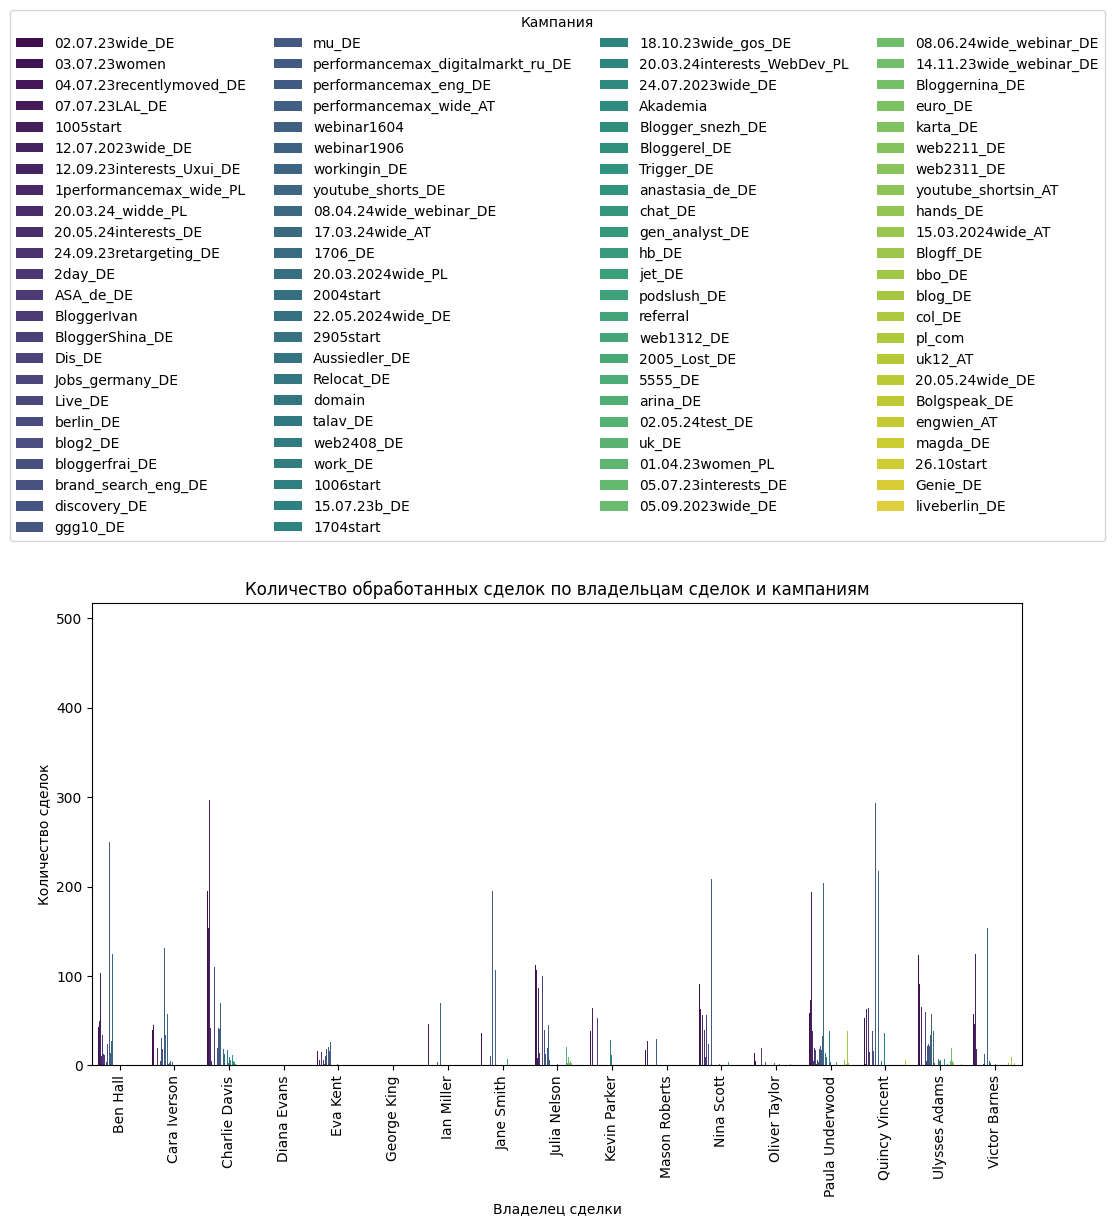

In [12]:
# Визуализация данных

# 1. Количество обработанных сделок по владельцам сделок и кампаниям
plt.figure(figsize=(12, 6))
sns.barplot(x='Deal Owner Name', y='total_deals', hue='Campaign', data=filtered_analysis, palette='viridis')
plt.xticks(rotation=90)
plt.title('Количество обработанных сделок по владельцам сделок и кампаниям')
plt.xlabel('Владелец сделки')
plt.ylabel('Количество сделок')
plt.legend(title='Кампания', bbox_to_anchor=(0.5, 2.3), loc='upper center', ncol=4)  # Легенда сверху в один ряд
plt.tight_layout()
plt.show()



### На предоставленном графике отображено количество обработанных сделок по владельцам сделок и рекламным кампаниям. 
График показывает, насколько активно каждый из владельцев работает с различными рекламными кампаниями.

**Основные выводы**
**Разнообразие кампаний:

На графике видно, что каждый владелец сделок работает с различными рекламными кампаниями, что отражено разными цветами. Это говорит о том, что владельцы сделок распределяют свои усилия между несколькими источниками лидов, что может быть связано с разной целевой аудиторией или стратегией работы с клиентами.

**Наиболее активные владельцы сделок**:
David Jones, Paula Underwood, и Hanna Scott — это одни из наиболее активных владельцев, которые обработали наибольшее количество сделок. Их активность может говорить о высокой производительности или большом количестве лидов, поступающих в их распоряжение.
Ian Swift, Eva Lee, и John Smith также демонстрируют значительную активность, что может быть признаком их опыта или важности для компании.

**Наименьшая активность**:
Carl Wilson, Charlie Davis, и Mark Taylor обработали значительно меньшее количество сделок. Это может свидетельствовать о том, что они работают с менее объемными кампаниями, или о том, что у них есть другие обязанности, ограничивающие их участие в процессе обработки сделок.
Возможно, стоит проанализировать причины их меньшей активности — это может быть вызвано спецификой кампаний или различиями в подходах к работе.

**Распределение сделок по кампаниям**:
Визуально видно, что некоторые кампании имеют значительно больший вклад в количество обработанных сделок по сравнению с другими. Это может свидетельствовать о разной эффективности кампаний или о различиях в методах работы с различными типами клиентов.

**Взаимосвязь между владельцами сделок и кампаниями**:
На графике хорошо видно, какие владельцы сделок больше всего работают с определенными кампаниями. Это может дать понимание, какие кампании и клиенты больше подходят для определенных владельцев сделок.

**Рекомендации**:
**Оптимизация нагрузки**:
Необходимо убедиться, что нагрузка на владельцев сделок распределена равномерно. Важно учитывать, что слишком большая нагрузка может негативно сказаться на качестве работы, а слишком малая нагрузка может быть неэффективным использованием ресурсов.

**Перераспределение кампаний**:
Если некоторые владельцы сделок показывают отличные результаты в работе с определенными кампаниями, возможно, стоит рассмотреть перераспределение других кампаний в их пользу, чтобы повысить общую эффективность.

**Обучение и поддержка**:
Для владельцев сделок с меньшей активностью можно рассмотреть варианты обучения или поддержки, чтобы улучшить их результаты и помочь им более эффективно работать с кампаниями.

**Анализ эффективности кампаний**:
Проведение более детального анализа эффективности рекламных кампаний для каждого владельца сделок поможет выявить, какие кампании работают лучше всего и какие требуют оптимизации.

**Заключение**:
Этот график предоставляет ценную информацию о распределении работы между владельцами сделок и кампаниями. Это позволяет компании принимать обоснованные решения о распределении ресурсов, оптимизации кампаний и поддержке сотрудников, чтобы максимально повысить производительность и эффективность работы с клиентами.

C:\Users\ICH\AppData\Local\Temp\ipykernel_8852\2140473675.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


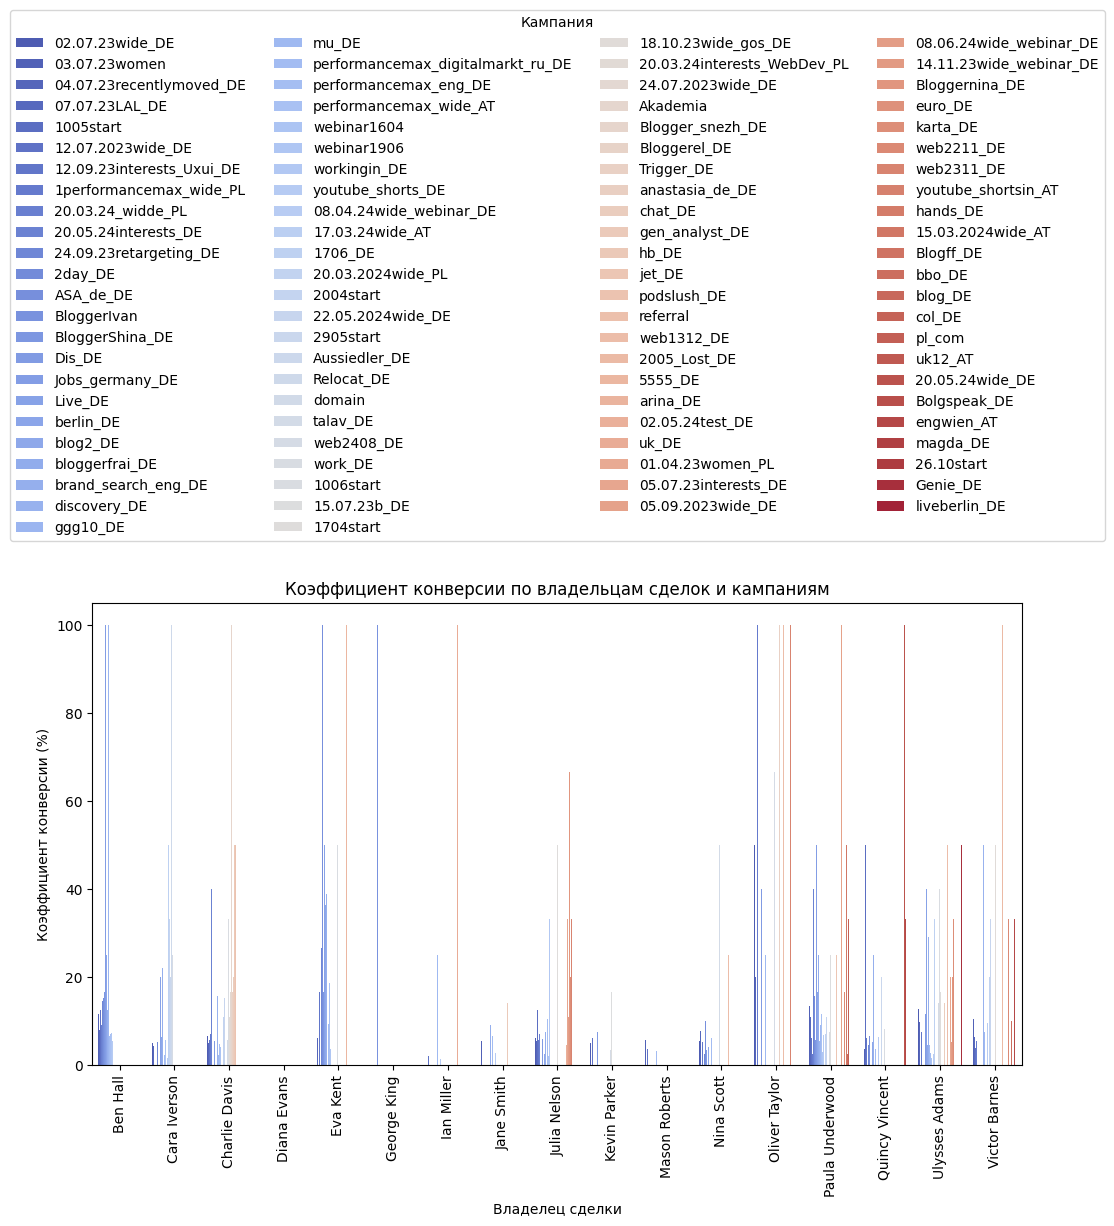

In [13]:
# 2. Коэффициент конверсии по владельцам сделок и кампаниям
plt.figure(figsize=(12, 6))
sns.barplot(x='Deal Owner Name', y='conversion_rate', hue='Campaign', data=filtered_analysis, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Коэффициент конверсии по владельцам сделок и кампаниям')
plt.xlabel('Владелец сделки')
plt.ylabel('Коэффициент конверсии (%)')
plt.legend(title='Кампания', bbox_to_anchor=(0.5, 2.3), loc='upper center', ncol=4)  # Легенда сверху в один ряд
plt.tight_layout()
plt.show()



In [ ]:
На предоставленном графике показан коэффициент конверсии по владельцам сделок и кампаниям. Коэффициент конверсии (%) отображает, насколько эффективно каждый владелец сделок конвертирует лидов из различных рекламных кампаний в успешные сделки.

Основные наблюдения:
Высокий коэффициент конверсии у отдельных владельцев:

Видно, что у некоторых владельцев сделок, таких как David Jones, Paula Underwood, и Hanna Scott, имеются пики коэффициента конверсии, достигающие высоких значений (до 100%). Это указывает на то, что они могут быть особенно успешными в конвертации лидов в сделки по определенным кампаниям.
Eva Lee и Ian Swift также показывают высокие коэффициенты конверсии для отдельных кампаний, что свидетельствует об их эффективности в работе с этими кампаниями.
Разнообразие коэффициентов конверсии:

У многих владельцев сделок коэффициенты конверсии варьируются между разными кампаниями. Это говорит о том, что эффективность каждого владельца сделок может значительно различаться в зависимости от специфики кампании.
Например, у John Smith коэффициент конверсии варьируется от низких до высоких значений, что указывает на возможные особенности работы с различными типами лидов или кампаний.
Кампании с низкими коэффициентами конверсии:

У некоторых владельцев сделок коэффициенты конверсии остаются низкими по большинству кампаний. Например, у Carl Wilson и Charlie Davis коэффициенты конверсии в целом ниже, что может указывать на трудности в работе с лидами или на низкое качество лидов из этих кампаний.
Это может быть сигналом к пересмотру их стратегий работы с определенными кампаниями или предоставлению им дополнительной поддержки и обучения.
Влияние конкретных кампаний:

Видно, что некоторые кампании показывают значительно лучшие результаты по сравнению с другими. Например, Paula Underwood и Hanna Scott показывают высокие коэффициенты конверсии для определенных кампаний, выделенных красным цветом на графике, что может свидетельствовать о хорошей синергии между этими владельцами и кампаниями.
Равномерное распределение:

У некоторых владельцев сделок коэффициенты конверсии распределены более равномерно между кампаниями. Это говорит о стабильной работе независимо от того, с какими кампаниями они работают, что может свидетельствовать о высоком уровне профессионализма и универсальности.
Рекомендации:
Оптимизация работы с кампаниями:

Владельцы сделок с низкими коэффициентами конверсии по определенным кампаниям могут нуждаться в анализе и корректировке своей стратегии работы с этими кампаниями. Возможно, стоит пересмотреть методы обработки лидов или предложить дополнительное обучение.
Масштабирование успешных кампаний:

Кампании, которые демонстрируют высокие коэффициенты конверсии для определенных владельцев, могут быть рассмотрены для масштабирования. Это может привести к увеличению количества успешных сделок и улучшению общих результатов компании.
Поддержка и обучение:

Владельцы сделок с равномерными высокими коэффициентами конверсии могут быть использованы в качестве примеров для обучения других сотрудников. Обмен лучшими практиками и успешными стратегиями поможет повысить общую эффективность команды.
Анализ кампаний с низкими результатами:

Кампании, которые показывают низкие результаты по всем владельцам сделок, должны быть рассмотрены для оптимизации или даже замены. Возможно, стоит пересмотреть таргетинг, креативы или условия предложения для повышения их эффективности.
Заключение:
График наглядно демонстрирует, как коэффициенты конверсии варьируются между владельцами сделок и кампаниями. Это позволяет выявить наиболее успешных владельцев и кампании, а также определить области, требующие улучшения. На основе этих данных можно принять обоснованные решения по оптимизации работы команды и рекламных кампаний для достижения наилучших результатов.








C:\Users\ICH\AppData\Local\Temp\ipykernel_8852\3123958507.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


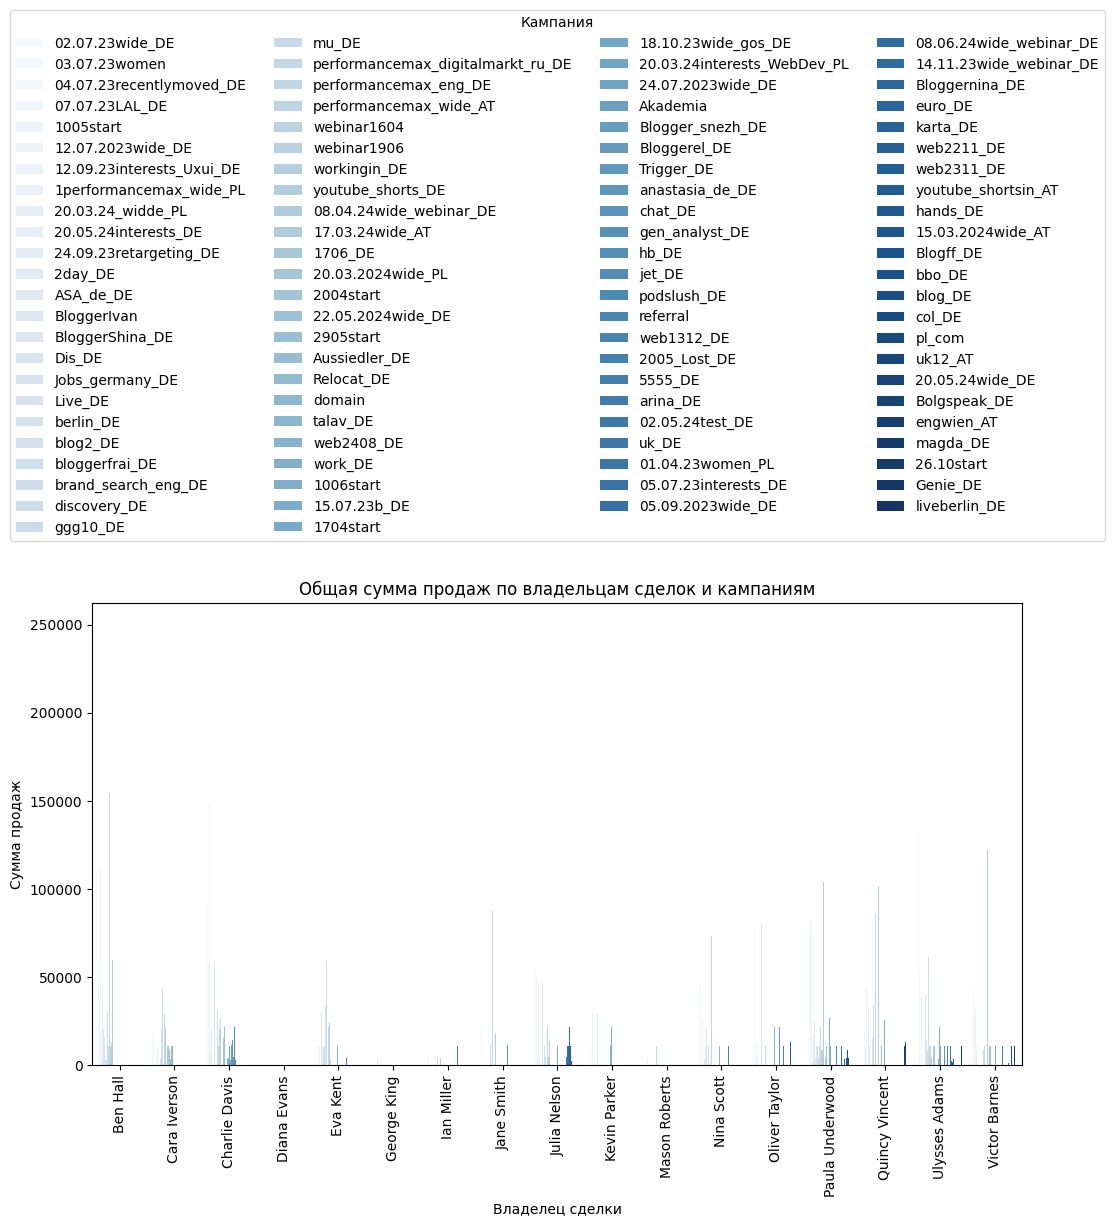

In [14]:
# 3. Общая сумма продаж по владельцам сделок и кампаниям
plt.figure(figsize=(12, 6))
sns.barplot(x='Deal Owner Name', y='total_sales', hue='Campaign', data=filtered_analysis, palette='Blues')
plt.xticks(rotation=90)
plt.title('Общая сумма продаж по владельцам сделок и кампаниям')
plt.xlabel('Владелец сделки')
plt.ylabel('Сумма продаж')
plt.legend(title='Кампания', bbox_to_anchor=(0.5, 2.3), loc='upper center', ncol=4)  # Легенда сверху в один ряд
plt.tight_layout()
plt.show()

### На представленном графике показана общая сумма продаж по владельцам сделок и кампаниям. 
График позволяет оценить вклад каждого владельца сделок и каждой рекламной кампании в общий объем продаж.

**Основные наблюдения**:
**Наибольший вклад в продажи**:
David Jones, Paula Underwood, и Hanna Scott — это владельцы сделок, которые вносят наибольший вклад в общую сумму продаж. Эти сотрудники обрабатывают сделки с наиболее высокими объемами продаж, что свидетельствует о их высокой эффективности в работе с клиентами и, вероятно, опыте в заключении крупных сделок.
Ian Swift и John Smith также показывают значительные суммы продаж, что делает их важными участниками процесса продаж в компании.

**Распределение продаж между кампаниями**:
Видно, что разные кампании приносят различный вклад в общий объем продаж. Например, некоторые кампании генерируют высокие объемы продаж только у определенных владельцев сделок, что может указывать на их способность эффективно работать с этими кампаниями.
Цветовые различия на графике помогают визуально отделить вклад разных кампаний, что может помочь в дальнейшем анализе эффективности каждой из них.

**Наименьший вклад в продажи**:
Carl Wilson, Charlie Davis, и Mark Taylor демонстрируют значительно меньшие объемы продаж по сравнению с другими владельцами сделок. Это может быть связано с тем, что они работают с меньшими по объему сделками или с кампаниями, которые в целом менее эффективны.
Возможно, эти владельцы нуждаются в дополнительной поддержке, обучении или перераспределении задач, чтобы повысить их вклад в общий объем продаж.

**Анализ эффективности кампаний**:
Некоторые кампании показывают значительные суммы продаж у большинства владельцев сделок, что указывает на их высокую эффективность. Такие кампании стоит рассматривать для масштабирования или для изучения успешных практик, которые могут быть перенесены на другие кампании.
Кампании, которые показывают низкие результаты по продажам, возможно, требуют пересмотра стратегии или изменений в подходе.

**Рекомендации**:
**Оптимизация распределения кампаний*:

Владельцы сделок с высокими суммами продаж могут быть усилены за счет увеличения их участия в наиболее успешных кампаниях. Это поможет максимально использовать их сильные стороны и увеличить общий объем продаж.

**Поддержка менее эффективных владельцев сделок**:

Владельцы сделок с низкими показателями продаж могут нуждаться в дополнительном обучении или коучинге. Возможно, стоит рассмотреть перераспределение задач, чтобы они могли сосредоточиться на кампаниях, где они могут быть более эффективны.

**Анализ кампаний с низкими результатами**:

Кампании, которые показывают низкие результаты по продажам, могут быть пересмотрены. Важно понять, что именно вызывает такие низкие показатели, и возможно, изменить стратегию их реализации.

**Сравнение с другими метриками**:

Общую сумму продаж следует сопоставить с другими метриками, такими как коэффициент конверсии, стоимость привлечения клиента (CPA) и рентабельность (ROI). Это позволит принимать более обоснованные решения о том, куда инвестировать больше ресурсов.

**Заключение**:
График общей суммы продаж по владельцам сделок и кампаниям наглядно показывает вклад каждого сотрудника и каждой кампании в общий успех компании. На основе этих данных можно принимать решения о перераспределении задач, оптимизации работы с кампаниями и предоставлении дополнительной поддержки сотрудникам, что в итоге приведет к увеличению общего объема продаж и эффективности компании.

In [ ]:
1. Количество обработанных сделок по владельцам сделок и кампаниям
Общие наблюдения:
График показывает, сколько сделок каждый владелец обработал для каждой рекламной кампании.
Визуализация помогает определить, какие кампании были наиболее активны для разных владельцев.
Анализ:
Если какой-то владелец обрабатывает больше сделок для определённой кампании, это может указывать на его специализацию или 
более высокую эффективность работы с определённым типом лидов.
Сравнение между владельцами и кампаниями помогает выявить сильные стороны каждого владельца и эффективности кампаний.

2. Коэффициент конверсии по владельцам сделок и кампаниям
Общие наблюдения:
Этот график отражает, как эффективно каждый владелец и кампания конвертируют лиды в успешные сделки.
Высокий коэффициент конверсии указывает на успешное завершение сделки.
Анализ:
Если у одного владельца высокий коэффициент конверсии в нескольких кампаниях, это может говорить о его высокой компетентности или 
удачном подборе целевой аудитории.
Кампании с низким коэффициентом конверсии могут требовать пересмотра стратегии или лучшей подготовки владельцев сделок.
Сравнение между разными владельцами и кампаниями помогает выявить лучшие практики и перенять их для менее успешных.

3. Общая сумма продаж по владельцам сделок и кампаниям
Общие наблюдения:
График демонстрирует, сколько денег было заработано каждым владельцем через определённые кампании.
Высокие суммы продаж говорят о более прибыльных сделках.
Анализ:
Если какой-то владелец генерирует значительно больше продаж, возможно, ему удается лучше заключать крупные сделки, или он работает 
с более дорогими продуктами.
Разные кампании могут показывать различные уровни доходности. Кампании, которые приводят к высоким продажам, возможно, требуют
большего внимания и ресурсов.
Если кампании, которые генерируют много сделок, при этом имеют низкую общую сумму продаж, это может означать, что средний размер сделки мал 
и стоит подумать об увеличении чека.
Заключение:
Сильные стороны: Выявить сильные стороны как отдельных владельцев сделок, так и рекламных кампаний. Это позволяет лучше понимать, где ресурсы 
тратятся с наибольшей эффективностью.
Области для улучшения: Обратить внимание на владельцев и кампании с низкими показателями, чтобы улучшить их работу, возможно, через обучение 
или изменение стратегии.
Стратегические решения: На основе анализа можно принять решение о перераспределении ресурсов, усилении успешных кампаний или корректировке 
неэффективных.